In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv

import matplotlib.pyplot as plt

Seed the RNG for reproducibility:

In [2]:
torch.manual_seed(1234567)

Download the Cora dataset

In [3]:
dataset = Planetoid(root='data/Planetoid', name='Cora')

In [4]:
data = dataset[0] # dataset has 1 graph

print("Cora graph has:")
print(f"#nodes: {data.num_nodes}")
print(f"#edges: {data.num_edges}")

Cora graph has:
#nodes: 2708
#edges: 10556


Two convolutional layers, convolution described here: [Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)

In [13]:
class GCN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(input_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, output_size)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(input_size=dataset.num_features, 
            hidden_size=16, 
            output_size=dataset.num_classes)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [12]:
def train():
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index) # get logits

    loss = criterion(out[data.train_mask], data.y[data.train_mask]) # compute loss

    loss.backward()
    optimizer.step()
    
    return loss

def val_loss():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)

        loss = criterion(out[data.val_mask], data.y[data.val_mask])

    return loss

def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)  # pick class with highest probability
        test_correct = pred[data.test_mask] == data.y[data.test_mask]
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # compute accuracy
    return test_acc

In [ ]:
print_every = 25

train_loss_history = []
val_loss_history = []

for epoch in range(1, 101):
    
    loss = train()
    train_loss_history.append(loss.item())

    val_loss = val_loss()
    val_loss_history.append(val_loss)

    if epoch % print_every == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 025, Loss: 0.1938
Epoch: 050, Loss: 0.0486
Epoch: 075, Loss: 0.0510
Epoch: 100, Loss: 0.0422


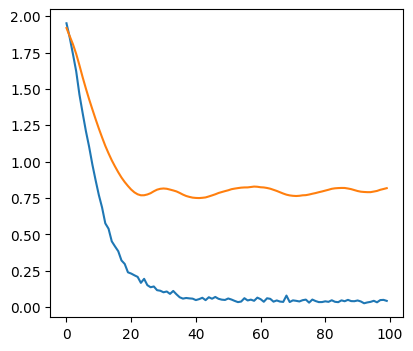

In [16]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.show()

In [19]:
test_acc = test()

print(f"Test accuracy = {test_acc}")

Test accuracy = 0.791
